In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
from cv2 import resize
from glob import glob

In [3]:
img_height = 224
img_width = 224


train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/CNN/input/animals',
  validation_split=0.2,
  subset='training',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

val_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/drive/MyDrive/CNN/input/animals',
  validation_split=0.2,
  subset='validation',
  image_size=(img_height, img_width),
  batch_size=32,
  seed=42,
  shuffle=True)

Found 3063 files belonging to 90 classes.
Using 2451 files for training.
Found 3063 files belonging to 90 classes.
Using 612 files for validation.


In [4]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False # Freeze VGG-16 for now

58889256/58889256 [==============================] - 0s 0us/step


In [5]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.vgg16.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(90)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [7]:
num_epochs = 10
model.fit(train_ds, validation_data=val_ds, epochs=num_epochs,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=2,
            verbose=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
77/77 [==============================] - 376s 4s/step - loss: 12.8015 - accuracy: 0.1020 - val_loss: 4.1658 - val_accuracy: 0.3791
Epoch 2/10
77/77 [==============================] - 21s 262ms/step - loss: 5.1567 - accuracy: 0.3807 - val_loss: 2.2500 - val_accuracy: 0.6291
Epoch 3/10
77/77 [==============================] - 22s 267ms/step - loss: 2.9188 - accuracy: 0.5594 - val_loss: 1.5085 - val_accuracy: 0.7271
Epoch 4/10
77/77 [==============================] - 22s 264ms/step - loss: 1.9201 - accuracy: 0.6593 - val_loss: 1.3684 - val_accuracy: 0.7729
Epoch 5/10
77/77 [==============================] - 22s 266ms/step - loss: 1.3004 - accuracy: 0.7385 - val_loss: 1.2794 - val_accuracy: 0.7859
Epoch 6/10
77/77 [==============================] - 21s 260ms/step - loss: 1.0022 - accuracy: 0.7785 - val_loss: 1.1004 - val_accuracy: 0.8301
Epoch 7/10
77/77 [==============================] - 21s 263ms/step - loss: 0.7606 - accuracy: 0.8213 - val_loss: 1.1091 - val_accuracy: 0.8268


In [8]:
# fine tuning
base_model.trainable = True
for layer in base_model.layers[:14]:
    layer.trainable = False
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), # use a lower learning rate when fine-tuning
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
num_epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=num_epochs,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            # Stop training when `val_loss` is no longer improving
            monitor="val_loss",
            # "no longer improving" being defined as "no better than 1e-2 less"
            min_delta=1e-2,
            # "no longer improving" being further defined as "for at least 2 epochs"
            patience=2,
            verbose=1,
        )
    ]
)

Epoch 1/5
77/77 [==============================] - 24s 280ms/step - loss: 0.8595 - accuracy: 0.7630 - val_loss: 0.9038 - val_accuracy: 0.8170
Epoch 2/5
77/77 [==============================] - 22s 274ms/step - loss: 0.3128 - accuracy: 0.9098 - val_loss: 0.8115 - val_accuracy: 0.8513
Epoch 3/5
77/77 [==============================] - 22s 275ms/step - loss: 0.1702 - accuracy: 0.9486 - val_loss: 0.8753 - val_accuracy: 0.8464
Epoch 4/5
77/77 [==============================] - 22s 274ms/step - loss: 0.1329 - accuracy: 0.9604 - val_loss: 0.8578 - val_accuracy: 0.8431
Epoch 4: early stopping


Text(0, 0.5, 'Accuracy')

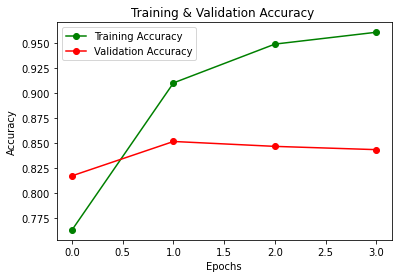

In [11]:
plt.figure()
i_train_acc = history.history['accuracy']
i_val_acc = history.history['val_accuracy']
i_epoch = [i for i in range(len(i_val_acc))]
plt.plot(i_epoch , i_train_acc , 'go-' , label = 'Training Accuracy')
plt.plot(i_epoch, i_val_acc , 'ro-' , label = 'Validation Accuracy')
plt.title('Training & Validation Accuracy ')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

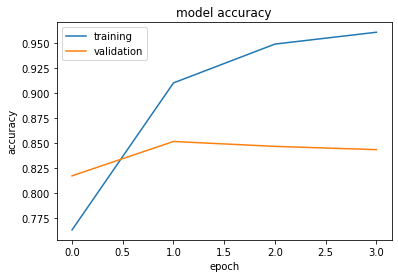

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks()
plt.yticks()
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

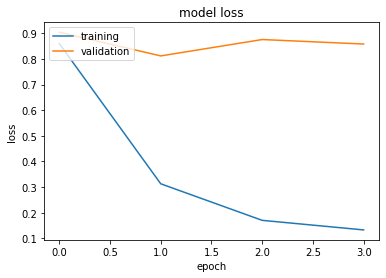

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks()
plt.yticks()
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [14]:
from keras.models import load_model
model.save('/content/drive/MyDrive/CNN/input/my_model.h5')

In [15]:
model = load_model('/content/drive/MyDrive/CNN/input/my_model.h5')

1/1 [==============================] - 0s 16ms/step
/content/drive/MyDrive/CNN/input/animals/butterfly/914e36917d.jpg most likely belongs to butterfly with a 100.00 percent confidence.


(-0.5, 223.5, 223.5, -0.5)

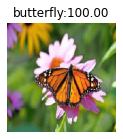

In [19]:
img_name = random.choice(glob('/content/drive/MyDrive/CNN/input/animals/*/*.jpg'))
#img_name = '/content/drive/MyDrive/CNN/panda.jpg'
img = tf.keras.utils.load_img(img_name, target_size=(img_height, img_width))

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "{} most likely belongs to {} with a {:.2f} percent confidence."
    .format(img_name, train_ds.class_names[np.argmax(score)], 100 * np.max(score))
)

plt.figure(figsize=(2, 2))
plt.imshow((img_array[0].numpy()).astype('uint8'))
plt.title("{}:{:.2f}".format(train_ds.class_names[np.argmax(score)], 100 * np.max(score)))
plt.axis('off')